In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import math
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import re

In [3]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [6]:
genres_dict = dict()
for movie in movie_ids:
    for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
        if genre in genres_dict.keys():
            genres_dict[genre] = genres_dict[genre] + 1
        else: genres_dict[genre] = 1

In [7]:
genres_dict = {k: v for k, v in sorted(genres_dict.items(), key=lambda item: item[1],reverse=True)}
genres_dict

{'Drama': 4349,
 'Comedy': 3753,
 'Thriller': 1889,
 'Action': 1828,
 'Romance': 1591,
 'Adventure': 1262,
 'Crime': 1196,
 'Sci-Fi': 980,
 'Horror': 977,
 'Fantasy': 778,
 'Children': 664,
 'Animation': 610,
 'Mystery': 573,
 'Documentary': 438,
 'War': 381,
 'Musical': 333,
 'Western': 167,
 'IMAX': 158,
 'Film-Noir': 85,
 '(no genres listed)': 34}

In [8]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [9]:
embedding_dim = 32
hidden_units = [64, 32]

user_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='user_input')
movie_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='movie_input')

user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=embedding_dim,name='user_embedding')(user_input)
movie_embedding = tf.keras.layers.Embedding(input_dim=num_movies, output_dim=embedding_dim)(movie_input)

user_embedding = tf.keras.layers.Flatten()(user_embedding)
movie_embedding = tf.keras.layers.Flatten()(movie_embedding)

concatenated = tf.keras.layers.Concatenate()([user_embedding, movie_embedding])

for units in hidden_units:
    concatenated = tf.keras.layers.Dense(units, activation='relu')(concatenated)

output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)

model = tf.keras.Model(inputs=[user_input, movie_input], outputs=output)

model.compile(optimizer="Adam",loss="mse")

In [10]:
history = model.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    batch_size=64,
    epochs=5
)

Epoch 1/5
1418/1418 [==============================] - 17s 10ms/step - loss: 0.0405 - val_loss: 0.0384
Epoch 2/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0339 - val_loss: 0.0371
Epoch 3/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0312 - val_loss: 0.0373
Epoch 4/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0287 - val_loss: 0.0379
Epoch 5/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.0262 - val_loss: 0.0395


In [11]:
user_embeddings = model.get_layer('user_embedding').get_weights()[0]

similarity_matrix = 1 - cosine_distances(user_embeddings)

In [12]:
display(pd.DataFrame(similarity_matrix))

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.285418,-0.806382,0.135930,0.052440,-0.003549,-0.246809,0.430404,0.273616,-0.589087,...,0.720941,-0.604342,-0.067582,0.030867,-0.495164,0.398875,0.405180,-0.360038,-0.623850,0.566013
1,0.285418,1.000000,-0.058001,-0.354061,-0.086375,0.597004,-0.357433,0.054630,-0.157486,0.286775,...,0.434065,-0.147612,-0.660649,0.329015,0.003481,-0.272202,0.454373,0.246409,-0.068475,-0.011572
2,-0.806382,-0.058001,1.000000,-0.052341,-0.222837,0.055358,0.358148,-0.494649,0.058052,0.454453,...,-0.715300,0.346518,-0.087809,-0.243016,0.196653,-0.615238,-0.389326,0.508797,0.457039,-0.351329
3,0.135930,-0.354061,-0.052341,1.000000,0.361786,-0.492883,0.160512,0.007387,0.419655,-0.455355,...,-0.353705,-0.305575,0.459530,-0.588287,-0.584290,0.204646,-0.094331,0.065329,-0.278969,0.334030
4,0.052440,-0.086375,-0.222837,0.361786,1.000000,-0.556193,-0.434806,0.337778,-0.073951,0.028158,...,0.025495,-0.029776,0.408957,0.248930,-0.066079,0.411137,0.197908,0.074528,0.075097,-0.006024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.398875,-0.272202,-0.615238,0.204646,0.411137,-0.353046,-0.223564,0.283626,-0.047754,-0.316977,...,0.205477,-0.058459,0.375632,0.241274,-0.167676,1.000000,0.027303,-0.340482,-0.127308,0.166380
606,0.405180,0.454373,-0.389326,-0.094331,0.197908,0.249340,-0.550967,0.246150,-0.168206,0.073914,...,0.407815,-0.120708,-0.135359,0.382774,-0.113247,0.027303,1.000000,-0.249532,-0.260046,-0.160229
607,-0.360038,0.246409,0.508797,0.065329,0.074528,0.009189,-0.103329,-0.104473,0.142240,0.327793,...,-0.256179,0.085450,-0.162009,-0.060006,0.071879,-0.340482,-0.249532,1.000000,0.368166,-0.042369
608,-0.623850,-0.068475,0.457039,-0.278969,0.075097,0.150853,-0.170712,-0.206876,-0.234614,0.472628,...,-0.257069,0.700415,-0.168885,0.397950,0.641979,-0.127308,-0.260046,0.368166,1.000000,-0.299415


In [13]:
target_user_id = 2
n_clusters = 5

In [14]:
k_means = KMeans(n_clusters = n_clusters,n_init = 'auto').fit(user_embeddings)

In [15]:
target_cluster = k_means.labels_[target_user_id - 1]

In [16]:
def TF_IDF():
    top_10_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(10))['movieId']
    res = dict()
    for movie in movie_ids:
        if top_10_fav_movies.value_counts().get(movie) is not None:
            res[movie] = (df['movieId'].value_counts().get(movie) / len(df)) * math.log(num_users/ top_10_fav_movies.value_counts().get(movie))
        else: res[movie] = 0.003
    return res

In [17]:
TF_IDF_matrix = TF_IDF()
TF_IDF_matrix

{1: 0.006422668875536696,
 3: 0.0027408071200956093,
 6: 0.003973901536680296,
 47: 0.005872318748535026,
 50: 0.005319240568277356,
 70: 0.0031200875452557387,
 101: 0.003,
 110: 0.005742300263168023,
 151: 0.0023191444862347465,
 157: 0.003,
 163: 0.002924136432775942,
 216: 0.0023344542741870916,
 223: 0.003892833603727024,
 231: 0.005422133205750431,
 235: 0.003334934677410131,
 260: 0.00612892245710925,
 296: 0.0063011586669572146,
 316: 0.005575180647900136,
 333: 0.0022916912054917397,
 349: 0.0039056191979275805,
 356: 0.0065078884222200374,
 362: 0.0015583500197343832,
 367: 0.007479782062191294,
 423: 0.003,
 441: 0.0022137288277695307,
 457: 0.005332307941163244,
 480: 0.007540072845880431,
 500: 0.005734471523554426,
 527: 0.0053304053075821315,
 543: 0.002607717652860701,
 552: 0.0032151775831890804,
 553: 0.002649914724614872,
 590: 0.004845822597483861,
 592: 0.007363405788554667,
 593: 0.006463188763933485,
 596: 0.0028585154377801123,
 608: 0.0054678440836580175,
 648:

In [18]:
users_cluster = np.where(k_means.labels_ == target_cluster)[0] + 1
num_users_cluster = len(users_cluster)
top_30_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(30))

(sum(top_30_fav_movies[(top_30_fav_movies.userId.isin(users_cluster)) & 
                                                   (top_30_fav_movies.movieId == 1)]['rating'].astype(int)) * TF_IDF_matrix[1]) / num_users_cluster

0.004775830702322159

In [19]:
def get_recommended_movies_for_cluster(target_cluster):
    movies_dict = dict()
    users_cluster = np.where(k_means.labels_ == target_cluster)[0] + 1
    num_users_cluster = len(users_cluster)
    top_20_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(20))
    for movie_id in movie_ids:
        sum_ratings = sum(top_20_fav_movies[(top_20_fav_movies.userId.isin(users_cluster)) & (top_20_fav_movies.movieId == movie_id)]['rating'].astype(int))
        if(sum_ratings != 0):
            movies_dict[movie_id] = (sum_ratings * TF_IDF_matrix[movie_id]) / num_users_cluster 
    movies_dict = {k: v for k, v in sorted(movies_dict.items(), key=lambda item: item[1],reverse=True)}
    return movies_dict

In [20]:
get_recommended_movies_for_cluster(0)

{356: 0.008397275383509725,
 318: 0.006497451049636494,
 296: 0.005081579570126786,
 110: 0.0047049815059505735,
 2571: 0.004216193510219215,
 593: 0.004211497194563109,
 260: 0.0038750606503013324,
 480: 0.003648422344780854,
 589: 0.0033733940474065453,
 150: 0.0032797604443224075,
 2959: 0.0031814385773610483,
 527: 0.0029575152029165377,
 47: 0.002955102337972465,
 457: 0.0028553648975261246,
 590: 0.002751176700506966,
 1: 0.002693377270386357,
 1198: 0.002593015477232157,
 1210: 0.0025211916259561614,
 380: 0.0024878783760681035,
 4306: 0.002414382776900686,
 50: 0.002367919994910565,
 608: 0.002363519700677982,
 648: 0.0023616046146231508,
 2858: 0.0021682052791840503,
 595: 0.002106326567395202,
 1270: 0.00196581376241998,
 1196: 0.0019360494662574647,
 364: 0.001853719298101282,
 2028: 0.0017587533420399197,
 6539: 0.0017461925188492892,
 3578: 0.0017243537386420938,
 592: 0.0017102103766965676,
 1036: 0.0016765289847980758,
 858: 0.0016251579290983101,
 153: 0.001600153910654

In [21]:
def get_favourite_movies(target_user_id, n):
    movies_watched_by_user = df[df.userId == target_user_id]
    top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(n)
    .movieId.values
    )
    return top_movies_user

def get_recommended_movies(target_user_id,n):
    movies_watched_by_user = df[df.userId == target_user_id]
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(target_user_id)
    user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict([user_movie_array[:, 0],user_movie_array[:, 1]]).flatten()
    top_ratings_indices = ratings.argsort()[-n:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
    return recommended_movie_ids

In [22]:
favourite_movies = get_favourite_movies(target_user_id,10)
favourite_movies_df = movie_df[movie_df.movieId.isin(favourite_movies)]
for row in favourite_movies_df.itertuples():
    print(row.title, ":", row.genres)

Good Will Hunting (1997) : Drama|Romance
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Step Brothers (2008) : Comedy
Inglourious Basterds (2009) : Action|Drama|War
Town, The (2010) : Crime|Drama|Thriller
Inside Job (2010) : Documentary
Warrior (2011) : Drama
Wolf of Wall Street, The (2013) : Comedy|Crime|Drama
Mad Max: Fury Road (2015) : Action|Adventure|Sci-Fi|Thriller
The Jinx: The Life and Deaths of Robert Durst (2015) : Documentary


In [23]:
genres_4 = dict()
genres_5 = dict()
movies_watched_by_user = df[df.userId == target_user_id]
for movie in movies_watched_by_user.itertuples():
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 5):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_5.keys()):
                genres_5[genre] = genres_5[genre] + 1
            else: genres_5[genre] = 1
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 4):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_4.keys()):
                genres_4[genre] = genres_4[genre] + 1
            else: genres_4[genre] = 1

In [24]:
genres_recommended = dict()
recommended_movies = get_recommended_movies(target_user_id,50)
for movie in recommended_movies:
    for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended.keys()):
                genres_recommended[genre] = genres_recommended[genre] + 1
            else: genres_recommended[genre] = 1

303/303 [==============================] - 1s 3ms/step


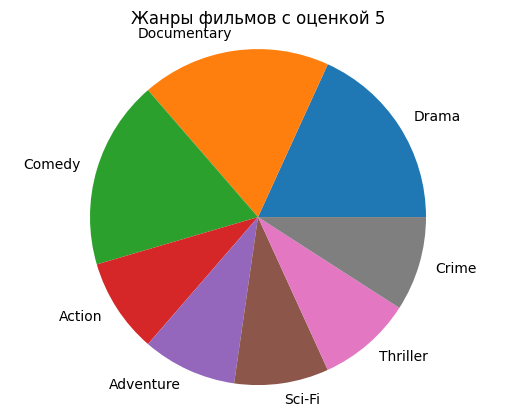

In [25]:
labels = []
sizes = []
for x, y in genres_5.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 5')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

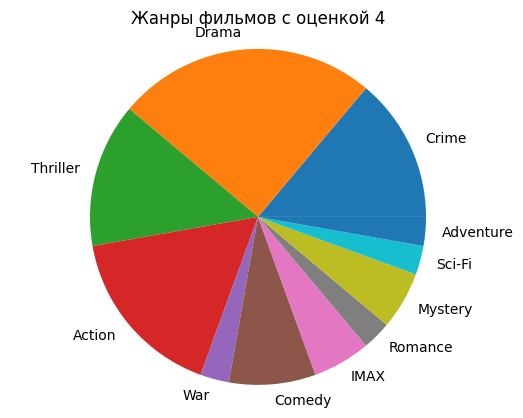

In [26]:
labels = []
sizes = []
for x, y in genres_4.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 4')
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

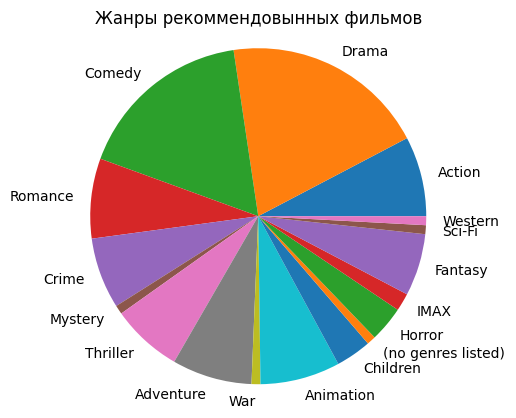

In [27]:
labels = []
sizes = []
for x, y in genres_recommended.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры рекоммендовынных фильмов')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

In [28]:
def top_n_similar_users(user_id,n):
    return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-n:] + 1

In [29]:
def nth_similar_user(user_id,n):
     return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-(n + 1)] + 1

In [30]:
rmse = 0
n = 10
similar_users = top_n_similar_users(target_user_id,n)
movies_watched_by_user = df[df.userId == target_user_id]
df_user = movies_watched_by_user[['movieId', 'rating']]

for similar_user_id in similar_users:
    movies_watched_by_similar_user = df[df.userId == similar_user_id]
    df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
    corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']            
    for movie_id in corresponding_movie_ids:
        rmse += math.pow(df_user[df_user.movieId == movie_id].iloc[0]['rating'] - 
                         df_similar_user[df_similar_user.movieId == movie_id].iloc[0]['rating'],2)
    rmse = math.sqrt(rmse*1/n)
    print(str(rmse) + str(corresponding_movie_ids.shape))

0.3535533905932738(2,)
0.1880301546543197(0,)
0.41085644143110617(5,)
0.20269594012488415(0,)
0.4693288761758522(2,)
0.6869737168317178(3,)
0.8477602088345334(3,)
0.7967283231337099(3,)
0.8829908449770989(11,)
0.7670065739599041(2,)


In [31]:
tmp_user = []
tmp_similar_user = []
similar_user_id = similar_users[1]

str_target = 'user ' + str(target_user_id)
str_similar = 'user ' + str(similar_user_id)

movies_watched_by_similar_user = df[df.userId == similar_user_id]
df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']

comparison_df = pd.DataFrame(index=corresponding_movie_ids,columns=[str_target,str_similar])

for i in corresponding_movie_ids:
    tmp_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == target_user_id)]['rating'].iloc[0]))
    tmp_similar_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == similar_user_id)]['rating'].iloc[0]))
    
comparison_df[str_target] = tmp_user
comparison_df[str_similar] = tmp_similar_user
comparison_df

,user 2,user 578
movieId,,


In [32]:
def get_recommended_movies_for_all_clusters(label):
    movies_for_clusters = dict()
    for i in range(n_clusters):
        movies_for_clusters[i] = get_recommended_movies_for_cluster(i)
    return movies_for_clusters

In [33]:
%%capture
movies_for_clusters = get_recommended_movies_for_all_clusters(k_means.labels_)

KeyboardInterrupt: 

In [34]:
movies_for_clusters

NameError: name 'movies_for_clusters' is not defined

In [ ]:
%%capture
genres_recommended_for_all_clusters = dict()
genres_recommended_tmp = dict()
for cluster in movies_for_clusters.keys():
    num_users_cluster = len(np.where(k_means.labels_ == cluster)[0])
    for movie in movies_for_clusters[cluster].keys():
        for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended_tmp.keys()):
                genres_recommended_tmp[genre] = genres_recommended_tmp[genre] + 1
            else: genres_recommended_tmp[genre] = 1
    genres_recommended_tmp = {k: v for k, v in sorted(genres_recommended_tmp.items(), key=lambda item: item[1],reverse=True)}
    for key in genres_recommended_tmp.keys():
        genres_recommended_tmp[key] = (genres_recommended_tmp[key]/num_users_cluster)
    genres_recommended_for_all_clusters[cluster] = genres_recommended_tmp
    genres_recommended_tmp = dict()

In [ ]:
genres_recommended_for_all_clusters

In [ ]:
for i in genres_recommended_for_all_clusters.keys():
    labels = []
    sizes = []
    for x, y in genres_recommended_for_all_clusters[i].items():
        labels.append(x)
        sizes.append(y)
    plt.title('Жанры рекоммендовынных фильмов для кластера: ' + str(i))
    plt.pie(sizes, labels=labels)
    plt.axis('equal')

    plt.show()

In [ ]:
movie_df[movie_df.movieId == 1]['title'].to_string()

In [ ]:
for movie in movies_for_clusters[0].keys():
    row = movie_df[movie_df.movieId == movie]
    print(row['title'].to_string() + str(list(row['genres'])))

In [ ]:
for movie in movies_for_clusters[4].keys():
    row = movie_df[movie_df.movieId == movie]
    print(row['title'].to_string() + str(list(row['genres'])))

In [ ]:
recommended_movies = movie_df[(movie_df["movieId"].isin(movies_for_clusters[1].keys()))]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)